
Date created: 27th May 2020

This script is to do the complete analysis for the 'precursor' and the 'prompt+afterglow' search. For each of the search, we do the following:

1. Calculate the TS and the respective p-values for each GRB.
2. Do the Binomial test for the list of p-values.
3. Report the final p-value for the respective search by comparing the best Binomial p-value obtained to a list of best binomial p-values. 
4. Compare the SB ratios for the events contibuting to the top ns*3 cases in each of the top k GRBs in order to determine correlations within the top k GRBs.

NB: 
Some abbreviations used:
    AG: Afterglow
    PC: Precursor


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import astropy
import histlite as hl
import csky as cy
import os
import pandas as pd
import random 
from astropy.coordinates import SkyCoord
import pickle

from csky.ipyconfig import *
from csky import *
import matplotlib
matplotlib.use('Agg')

%matplotlib inline 

'cy.plotting.mrichman_mpl()\ncy.plotting.mpl_tex_rc(sans=True)'

In [2]:
# set up timer
timer = cy.timing.Timer()
time = timer.time

In [3]:
def BinomialTest(pValues, kmax, returnArray=False):
    pSorted = np.sort(pValues)
    n = len(pSorted)
    if (kmax==0):
        kmax = n       # default:  search the whole array for best p-value
    i = np.arange(0,n)
    # NB the array index i = k-1.  We just need i in next line since we want sf(k-1) = sf(k)+pmf(k)
    BpArr = stats.binom.sf(i[:kmax],n,pSorted[:kmax])  # remember: test is w.r.t. n, even if we only search up to kmax
    BpBest = BpArr.min()
    kBest = BpArr.argmin()+1
    pThresh = pSorted[kBest-1]
    if returnArray:
        return pThresh, kBest, BpBest, BpArr
    else:
        return pThresh, kBest, BpBest

def ndarray_to_Chi2TSD(trials):
    return cy.dists.Chi2TSD(cy.utils.Arrays(trials))

In [4]:
#Loading the GFU offline data
repo = selections.Repository()
with time('ana setup'):
    ana = cy.get_analysis(cy.selections.repo,cy.selections.GFUDataSpecs.gfu_IC86)
    cy.CONF['ana'] = ana
    
min_data_set = ana.mjd_min
max_data_set = ana.mjd_max

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018...
Reading /data/ana/analyses/gfu/current/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC

In [5]:
# Load the complete GRB list
GRB_main_list = np.genfromtxt("GRBs_withoutheader.txt", 
                               dtype = [('GRB_name','S20'),('GRB_name_Fermi','S20'),('t_trigger','S20'),
                                        ('ra','Float64'), ('decl','float'), ('pos_error','Float64'), ('T90','Float64'), ('T90_error','Float64'),
                                        ('T90_start','S20'), ('fluence','Float64'),('fluence_error','Float64'),
                                        ('redshift','Float64'),
                                        ('T100','Float64'),
                                        ('GBM_located','bool'),
                                        ('mjd','Float64')
                                       ])

#GFU cut is between -85 and +85 degrees
my_selection = ((GRB_main_list['pos_error']>-1)*(GRB_main_list['pos_error']<0.2)*
                (GRB_main_list['decl']>-85.0)*(GRB_main_list['decl']<85.0)*
                (GRB_main_list['mjd']>(min_data_set+14.00))*(GRB_main_list['mjd']<(max_data_set-14.00)))

#The list of GRBs that will be analyzed for our analysis
GRBs_of_interest = GRB_main_list[my_selection]

In [6]:
#Data path for 10k background only prompt+afterglow searches done for each GRB
AG_trials_dir = cy.utils.ensure_dir('Background_AG_10k_each')
AG_bg_dir = cy.utils.ensure_dir('{}'.format(AG_trials_dir))

In [7]:
#Data path for 10k background only precursor searches done for each GRB
PC_trials_dir = cy.utils.ensure_dir('Background_PC_10k_each')
PC_bg_dir = cy.utils.ensure_dir('{}'.format(PC_trials_dir))

In [8]:
#Loading the respective data
with time('load AG bg trials'):
    AG_bg = cy.bk.get_all(
        # disk location
        '{}/ID'.format(AG_bg_dir),
        # filename pattern
        'trials*npy',
        # how to combine items within each directory
        merge=np.concatenate,
        # what to do with items after merge
        post_convert=ndarray_to_Chi2TSD)


0:00:59.027426 elapsed.


In [9]:
with time('load PC bg trials'):
    PC_bg = cy.bk.get_all(
        # disk location
        '{}/ID'.format(PC_bg_dir),
        # filename pattern
        'trials*npy',
        # how to combine items within each directory
        merge=np.concatenate,
        # what to do with items after merge
        post_convert=ndarray_to_Chi2TSD)


0:00:27.729344 elapsed.


Now we define the trial runner and use it to do the respective search

In [11]:
sources = cy.sources(GRBs_of_interest['ra'], GRBs_of_interest['decl'], deg=True)
MJD_GRB = GRBs_of_interest['mjd'] 

In [12]:
#Defining the prompt+afterglow search trial runners (Check the csky tutorials for more info)
def give_me_AG_tr(raGRB, decGRB, mjd_GRB):
    
    src = cy.utils.Sources(ra=np.radians(raGRB), dec=np.radians(decGRB))
    
    mjd_grb =  mjd_GRB
    #We just need to define even though we dont really use it
    inj_duration = 30 / 86400.
    
    search_duration = 14.00 
    
    afterglow = {
        # basics
        'ana':          ana,
        'src':          src,
        'flux':         cy.hyp.PowerLawFlux(2),
        # time-dep llh stuff
        'time':         'utf',
        'box':          True,
        'box_mode':     'post',
        'dt_max':       search_duration, #Maximum allowed Tw is 2 weeks
        'dt_min':       0.5 * (1/86400.0),# Minimum allowed tw is 0.5 s
        'seeder':       cy.seeding.UTFSeeder(threshold = 1),
        # time-dep injector. Even though we dont inject any signals, we do need to define them as per the code framework.
        'sig':          'tw',
        'sig_kw':       dict(t0=mjd_grb, dt=inj_duration, box_mode='post'), #These are just for the signal injection purposes
        #Note that the box_mode here is set to 'pre'. This is so that we can control injecting the size of pulses.
        # hold t0 fixed
        'fitter_args':  dict(t0=mjd_grb),
        # use multiprocessing
        'mp_cpus':      10,
        'prior':  None #prior =None is the key for removing the penalty term
    }
    
    return cy.conf.get_trial_runner(afterglow, extra_keep=['run', 'event'], cut_n_sigma=5)

#Get the trial runners for a ll the GRBs in the selection list
with time('AG trs setup'):
    AG_trs = [give_me_AG_tr(grb['ra'], grb['decl'], grb['mjd']) for grb in GRBs_of_interest]


0:01:41.908550 elapsed.


In [13]:
#defining the AG injector

inj_duration = 14.0
mjd_grb = 58386.61

afterglow = {
        # basics
        'ana':          ana,
        'src':          sources,
        'flux':         cy.hyp.PowerLawFlux(2),
        # time-dep llh stuff
        'time':         'utf',
        'box':          True,
        'box_mode':     'post',
        'dt_max':       14.0,
        'dt_min':       0.5 * (1/86400.0),
        'seeder':       cy.seeding.UTFSeeder(threshold = 1),
        # time-dep injector
        'inj_conf':     dict(src=sources),
        'sig':          'tw',
        'sig_kw':       dict(t0=mjd_grb, dt=inj_duration, box_mode='post'),
        #Note that the box_mode here is set to 'pre'. This is so that we can control injecting the size of pulses.
        # hold t0 fixed
        'fitter_args':  dict(t0=mjd_grb),
        # use multiprocessing
        'mp_cpus':      10,
        'prior':  None #prior =None is the key for removing the penalty term
        }

afterglow_inj = {}
afterglow_inj.update(afterglow)
del afterglow_inj['fitter_args']

tr_inj = cy.get_trial_runner(afterglow_inj, src=sources, inj_conf=dict(src=sources),extra_keep=['run', 'event']
                            )

In [14]:
#Defining the Multi trial runner to perform the analysis on the same scrambled sky
multr = cy.trial.MultiTrialRunner(
    # the Analysis
    ana,
    # bg+sig injection trial runner (produces trials)
    tr_inj,
    # llh test trial runners (perform fits given trials)
    AG_trs,
    # background distrubutions, can also do without this info since was getting some error when i use it
    #bgs=bg,
    # use multiprocessing
    mp_cpus=cy.CONF['mp_cpus'],
)

with time('Multi tr fitting'):
    #For unblinding, we change things here. These are for blind analysis.
    trial_kw = dict(n_sig=0, poisson=False, seed=34)
    trial_from_kw = multr.get_one_trial(**trial_kw)
    Fits_from_trial = multr.get_all_fits_from_trial(trial_from_kw) 

    


0:02:49.163149 elapsed.


In [15]:
#Getting the p-values from the TS values
array_fits_AG = np.asarray(Fits_from_trial)
one_TS_AG = np.core.records.fromarrays(array_fits_AG.transpose(), 
                                             names='PV, TS, Ns, Tw, Gamma',
                                             formats = 'Float64, Float64, Float64, Float64, Float64')


In [16]:
# Now we do the PV calculation from the TS calculation

get_1_TS_key = 3
if get_1_TS_key >1:
    with time('Getting p-values from the TS.Afterglow search.'):
        #To store this file
        name = "complete_analysis_AG_result_file.txt"
        mainfile = open(name, "w+")
        mainfile.close()  
        ID = 0

        for X in range(len(GRBs_of_interest)):
            
            #We determine p-v by comparing the TS to background. If the TS is zero, we set the p-value to 1
            ts_local = one_TS_AG[X]['TS']
            if ts_local >0.0:
                background_TS = AG_bg[X]
                p_value_of_interest = background_TS.sf(ts_local)
            else:
                p_value_of_interest = 1.0
            
            mainfile = open(name, "a")
            mainfile.write(str(ID)+' '+
                           str(GRBs_of_interest[X]['ra'])+' '+str(GRBs_of_interest[X]['decl'])+' '+
                           str(GRBs_of_interest[X]['mjd'])+' '+str(np.float(one_TS_AG[X]['Tw']))+' '+str(np.float(one_TS_AG[X]['Gamma']))+' '+
                           str(np.float(one_TS_AG[X]['Ns']))+' '+str(np.float(one_TS_AG[X]['TS']))+' '+str(p_value_of_interest)+'\n')
            mainfile.close()
            ID = ID +1

Afterglow_ID_TS_pv = np.genfromtxt("complete_analysis_AG_result_file.txt", 
                               dtype = [('ID','i4'),
                                        ('ra','Float64'), ('decl','Float64'),
                                        ('mjd','Float64'),('dt','Float64'),('gamma','Float64'),('ns','Float64'),('ts','Float64'),('pv','Float64')
                                       ])



0:00:01.398433 elapsed.


In [17]:
SORTED_LIST_AG = np.sort(Afterglow_ID_TS_pv, order='pv')

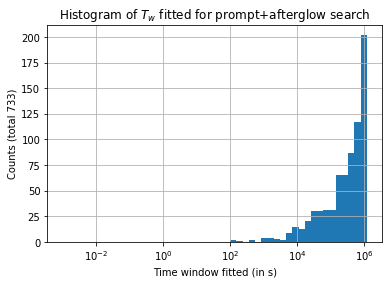

In [18]:
#Plotting the distribution of Time windows fitted for
plt.hist(Afterglow_ID_TS_pv['dt']*86400, bins=np.logspace(np.log10(0.001),np.log10(14*86400), 50))
plt.xlabel('Time window fitted (in s)')
plt.ylabel('Counts (total 733)')
plt.grid()
plt.xscale('log')
plt.title('Histogram of $T_w$ fitted for the prompt+afterglow search')
plt.savefig("T_w_fitted_s_Afterglow.png",dpi =200)
plt.show()

Now we do the Binomial testing for the after glow search

In [19]:
pValues = np.sort(Afterglow_ID_TS_pv['pv']) 
kmax = len(pValues)

#The Binomial test results
pBest_AG, kBest_AG, BpBest_AG, BpArr_AG = BinomialTest(pValues,kmax,returnArray=True)

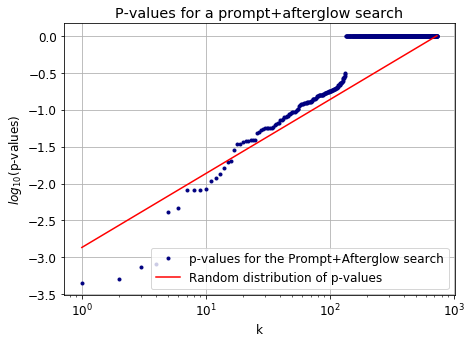

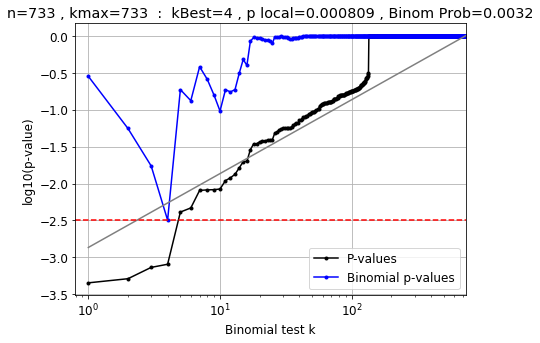

In [20]:
#Plotting the Binomial test result

p_value_data = np.sort(Afterglow_ID_TS_pv['pv'])
n = len(p_value_data)

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(1,n+1),np.log10(p_value_data), '.', color = 'navy', label ='p-values for the Prompt+Afterglow search')
plt.plot((1,n),(-np.log10(n),0),color='red', label = 'Random distribution of p-values')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$log_{10}$(p-values)')
plt.legend()
plt.title('P-values for the prompt+afterglow search')
plt.grid()
plt.savefig("PV_AG.png")
plt.show()

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(1,n+1),np.log10(pValues),marker='.',color='black', label = 'P-values')
plt.plot(np.arange(1,n+1),np.log10(BpArr_AG),marker='.',color='blue', label = 'Binomial p-values')
plt.plot((1,n),(-np.log10(n),0),color='gray')
plt.xlim(10**(-0.1),n+(10**(0.1)))
plt.xscale('log')
plt.title('n='+str(n)+' , kmax='+str(kmax)+'  :  kBest='+str(kBest_AG)+' , p local={:.3g}'.format(pBest_AG)+ 
          ' , Binom Prob={:.2g}'.format(BpBest_AG))
plt.xlabel('Binomial test k')
plt.ylabel('log10(p-value)')
plt.axhline(np.log10(BpBest_AG),color = 'red',linestyle='--')
plt.grid()
plt.legend()
plt.savefig("BT_AG.png",dpi =200)
plt.show()



Now we do the final post-trial p-value calculation for the afterglow search
    


In [21]:
def give_final_pv(BP_list, Bp_Best):
    Sorted_case = np.sort(BP_list)

    for x in range(len(Sorted_case)):
        if Sorted_case[x] >Bp_Best:
            print(x)
            final_fraction = x
            break

    final_PV = final_fraction/len(Sorted_case)
    print(final_PV)
    return final_PV


In [22]:
#Loading the file which has distribution of the Best Binomial Probability based 
#on scrambled datasets containing possible correlations

filename = "BP_scrambled_bckg.p"
Bp_distribution = pickle.load(open(filename,"rb"))
len(Bp_distribution)

4180

In [23]:
final_PV_AG = give_final_pv(Bp_distribution,BpBest_AG)

116
0.027751196172248804


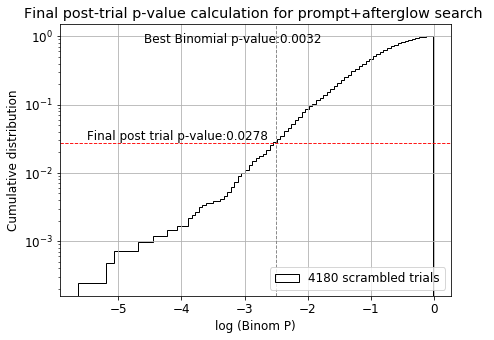

In [25]:
#Plotting the final PV
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.hist(np.log10(Bp_distribution), bins=100, cumulative=True, density=-1, histtype='step', color='black', label=str(len(Bp_distribution))+' scrambled trials')
plt.axvline(np.log10(BpBest_AG),color = 'grey', linestyle = '--', linewidth = 0.9)
plt.rcParams.update({'font.size': 12})
plt.text(-5.5, 1.1*final_PV_AG, r'Final post trial p-value:{:.3g}'.format(final_PV_AG))
plt.axhline(final_PV_AG ,color = 'red',linestyle = '--', linewidth = 0.9)
plt.text(-4.6, 0.8, r'Best Binomial p-value:{:.3g}'.format(BpBest_AG))
plt.xlabel('log (Binom P)')
plt.ylabel('Cumulative distribution')
plt.yscale('log')
plt.title('Final post-trial p-value calculation for the prompt+afterglow search ')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("Final_PV_AG.png",dpi =200)
plt.show()

Now we look for possible correlations in the top-k GRBs for this search


In [26]:
Top_k_GRBs_AG = SORTED_LIST_AG[:kBest_AG]

In [27]:
Top_k_GRBs_AG['dt'] = Top_k_GRBs_AG['dt']*86400

In [28]:
AG_TopKGRBS_pd = pd.DataFrame(Top_k_GRBs_AG , columns=['ID', 'ra', 'decl', 'mjd', 'dt', 'gamma', 'ns', 'ts', 'pv']) 
print(AG_TopKGRBS_pd)

    ID        ra     decl           mjd             dt     gamma        ns  \
0  526  230.0324   0.6276  56498.484155   11980.582920  2.687843  1.986668   
1  255  161.9513 -24.7891  57421.092477    1069.571915  4.000000  0.999928   
2  670  319.7641 -25.4626  55975.034282   25967.576194  3.320534  0.999782   
3  588  190.1013 -50.5941  56290.208576  537625.862998  2.476865  3.476351   

          ts        pv  
0  16.639010  0.000453  
1  17.086286  0.000515  
2  14.859086  0.000733  
3  14.943717  0.000809  


We set a threshold for which neutrinos contribute to a given GRB position as the top nsx3 neutrinos when ordered by S/B (where ns is the number of signal neutrinos identified by the fit, and S/B is the ratio of the likelihoods for the neutrino to be signal-like over background-like, taking into account the energy, position, and time of the neutrino). This criteria is taken from Erin's blazar analysis. Thus, for GRB in the top k list, we generate a list of neutrinos which contribute most to the fit at that position.

In [29]:
def give_S_over_B(trs_temp,trial_temp):
    L_temp = trs_temp.get_one_llh_from_trial(trial_temp)
    Fit_temp = L_temp.fit(**trs_temp.fitter_args)

    space_eval_temp = cy.inspect.get_space_eval(L_temp, -1, 0) # 0: background events (1 would be for signal events)
    energy_eval_temp = cy.inspect.get_energy_eval(L_temp, -1, 0)
    time_eval_temp = cy.inspect.get_time_eval(L_temp, -1, 0)

    SB_space_temp = space_eval_temp()[0]
    SB_energy_temp = energy_eval_temp(gamma= Fit_temp[1]['gamma'])[0]
    SB_time_temp = time_eval_temp(t0=trs_temp.fitter_args['t0'],dt =Fit_temp[1]['dt'])[0]
    SB_temp = SB_space_temp*SB_energy_temp*SB_time_temp
    
    SB_temp_list = np.core.records.fromarrays([SB_temp, energy_eval_temp.ev.idx, energy_eval_temp.ev.run,energy_eval_temp.ev.mjd], 
                                             names='S/B, event_index , run_ID, mjd',
                                             formats = 'Float64, i4, i4, Float64')
    
    #The 'event_index'' is a local event number based on the loaded data
    #the true event ID used in IceCube is 'ev.events' instead of 'ev.idx'.
    
    sorted_SB_temp_list = np.sort(SB_temp_list, order='S/B')
    Correlation_Criteria = np.int((Fit_temp[1]['ns']*3)+0.5)
    #print(Fit_temp[1]['ns'])
    return [sorted_SB_temp_list[-Correlation_Criteria:],Fit_temp[1]['ns']]

def PrettyPrintGrb(grb, TSfile):
    s = ' RA={:5.1f} Dec={:5.1f} T0={:7.6f}\n '.format(grb['ra'],grb['decl'],grb['mjd'])
    s += 'ns={:4.2f} p={:7.1e}  Tw={:7.1e}\n'.format(TSfile['ns'],TSfile['pv'],TSfile['dt'])
    return s

In [30]:
#Plotting the event details for the top-k GRBs

zed =1 
#This is to store the event details for the top -k cases
Top_k_trial_data_AG = []

for topk in Top_k_GRBs_AG:
    SB = give_S_over_B(AG_trs[topk['ID']],trial_from_kw)[0]
    Top_k_trial_data_AG.append(SB)
    SB_pd = pd.DataFrame(SB, columns=['S/B', 'event_index', 'run_ID', 'mjd']) 
    #mjd dtype changes somehow from 0.8decimal places to 0.6 decimal places when i use the pd.dataframe.
    #It however doesnt affect us much as we put an upper bound for tw to be 0.5s anyways.
    #Use the pd.dataframe just to present, not to store the data.
    print('\n GRB #'+str(zed))
    print(PrettyPrintGrb(GRBs_of_interest[topk['ID']],Afterglow_ID_TS_pv[topk['ID']]))
    print(SB_pd)
    zed = zed+1

    


 GRB #1
 RA=230.0 Dec=  0.6 T0=56498.484155
 ns=1.99 p=4.5e-04  Tw=1.4e-01

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1498993  131613  57994.264098
1  0.000000e+00      1499306  131620  56953.768359
2  0.000000e+00      1499489  131621  56421.594246
3  0.000000e+00      1499615  131621  56720.145034
4  7.493847e+07      1495037  131586  56498.622819
5  2.249745e+08      1207042  129478  56498.576005

 GRB #2
 RA=162.0 Dec=-24.8 T0=57421.092477
 ns=1.00 p=5.2e-04  Tw=1.2e-02

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1498952  131613  57217.198796
1  0.000000e+00      1499910  131623  58182.676563
2  2.094101e+10       695554  125550  57421.104856

 GRB #3
 RA=319.8 Dec=-25.5 T0=55975.034282
 ns=1.00 p=7.3e-04  Tw=3.0e-01

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1495710  131592  57054.803043
1  0.000000e+00      1499200  131614  56873.700655
2  6.875490e+09      1366283  130686  55975.334833

 GR

In [31]:
#Checking explicitly if there are any overlaps of events:

def Find_overlaps_in_trial(trial, exclude_zero=False, verbose=False):
    evs = [] # this will be a list of lists which contain events for each GRB
    if exclude_zero:
        evs = [src[src['S/B']>0]['event_index'] for src in trial]
    else:
        evs = [src['event_index'] for src in trial]
    overlaps = []    
    for i in np.arange(0, len(trial)-1):
        for j in np.arange(i+1, len(trial)):
            intersection = list(set(evs[i]) & set(evs[j]))
            if len(intersection):
                overlaps.append([i,j,intersection])
    if verbose:
        for ov in overlaps:
            print('GRBs',ov[0],'and',ov[1],'may have possible overlaps, event_nos: ',ov[2])
        if len(overlaps)<1:
            print('No overlaps')
    return(overlaps)

In [32]:
#Searching for overlaps for the Afterglow search
print('\nAll overlaps including S/B=0')
Find_overlaps_in_trial(Top_k_trial_data_AG,exclude_zero=False, verbose=True)
print('\nOnly for S/B>0')
Find_overlaps_in_trial(Top_k_trial_data_AG,exclude_zero=True, verbose=True)


All overlaps including S/B=0
No overlaps

Only for S/B>0
No overlaps


[]

This was all for prompt+afterglow, no we repeat the same for precursor search

In [33]:
#Defining the precursor search trial runners (Check the csky tutorials for more info)

def give_me_PC_tr(raGRB, decGRB, mjd_GRB):
    
    src = cy.utils.Sources(ra=np.radians(raGRB), dec=np.radians(decGRB))
    
    mjd_grb =  mjd_GRB
    #We just need to define even though we dont really use it
    inj_duration = 30 / 86400.
    
    search_duration = 14.00 
    
    precursor = {
        # basics
        'ana':          ana,
        'src':          src,
        'flux':         cy.hyp.PowerLawFlux(2),
        # time-dep llh stuff
        'time':         'utf',
        'box':          True,
        'box_mode':     'pre',
        'dt_max':       search_duration, #Maximum allowed Tw is 2 weeks
        'dt_min':       0.5 * (1/86400.0),# Minimum allowed tw is 0.5 s
        'seeder':       cy.seeding.UTFSeeder(threshold = 1),
        # time-dep injector. Even though we dont inject any signals, we do need to define them as per the code framework.
        'sig':          'tw',
        'sig_kw':       dict(t0=mjd_grb, dt=inj_duration, box_mode='pre'), #These are just for the signal injection purposes
        # hold t0 fixed
        'fitter_args':  dict(t0=mjd_grb),
        # use multiprocessing
        'mp_cpus':      10,
        'prior':  None #prior =None is the key for removing the penalty term
    }
    
    return cy.conf.get_trial_runner(precursor, extra_keep=['run', 'event'], cut_n_sigma=5)

#Get the trial runners for a ll the GRBs in the selection list
with time('PC trs setup'):
    PC_trs = [give_me_PC_tr(grb['ra'], grb['decl'], grb['mjd']) for grb in GRBs_of_interest]


0:01:39.464138 elapsed.


In [34]:
#defining the PC injector

inj_duration = 14.0
mjd_grb = 58386.61

precursor = {
        # basics
        'ana':          ana,
        'src':          sources,
        'flux':         cy.hyp.PowerLawFlux(2),
        # time-dep llh stuff
        'time':         'utf',
        'box':          True,
        'box_mode':     'pre',
        'dt_max':       14.0,
        'dt_min':       0.5 * (1/86400.0),
        'seeder':       cy.seeding.UTFSeeder(threshold = 1),
        # time-dep injector
        'inj_conf':     dict(src=sources),
        'sig':          'tw',
        'sig_kw':       dict(t0=mjd_grb, dt=inj_duration, box_mode='pre'),
        #Note that the box_mode here is set to 'pre'. This is so that we can control injecting the size of pulses.
        # hold t0 fixed
        'fitter_args':  dict(t0=mjd_grb),
        # use multiprocessing
        'mp_cpus':      10,
        'prior':  None #prior =None is the key for removing the penalty term
        }

precursor_inj = {}
precursor_inj.update(precursor)
del precursor_inj['fitter_args']

PC_tr_inj = cy.get_trial_runner(precursor_inj, src=sources, inj_conf=dict(src=sources),extra_keep=['run', 'event']
                            )

In [35]:
#Defining the Multi trial runner to perform the analysis on the same scrambled sky
multr_PC = cy.trial.MultiTrialRunner(
    # the Analysis
    ana,
    # bg+sig injection trial runner (produces trials)
    PC_tr_inj,
    # llh test trial runners (perform fits given trials)
    PC_trs,
    # background distrubutions, can also do without this info since was getting some error when i use it
    #bgs=bg,
    # use multiprocessing
    mp_cpus=cy.CONF['mp_cpus'],
)

with time('Multi tr fitting'):
    #For unblinding, we change things here. These are for blind analysis.
    trial_kw = dict(n_sig=0, poisson=False, seed=3)
    trial_from_kw_PC = multr_PC.get_one_trial(**trial_kw)
    Fits_from_trial = multr_PC.get_all_fits_from_trial(trial_from_kw_PC) 

   


0:03:05.801850 elapsed.


In [36]:
#Getting the p-values from the TS values
array_fits_PC = np.asarray(Fits_from_trial)
one_TS_PC = np.core.records.fromarrays(array_fits_PC.transpose(), 
                                             names='PV, TS, Ns, Tw, Gamma',
                                             formats = 'Float64, Float64, Float64, Float64, Float64')


# Now we do the PV calculation from the TS calculation

get_1_TS_key = 3
if get_1_TS_key >1:
    with time('Getting p-values from the TS. Precursor search.'):
        #To store this file
        name = "complete_analysis_PC_result_file.txt"
        mainfile = open(name, "w+")
        mainfile.close()  
        ID = 0

        for X in range(len(GRBs_of_interest)):
            
            #We determine p-v by comparing the TS to background. If the TS is zero, we set the p-value to 1
            ts_local = one_TS_PC[X]['TS']
            if ts_local >0.0:
                background_TS = PC_bg[X]#Will change herer after we get all the PC_bg files
                p_value_of_interest = background_TS.sf(ts_local)
            else:
                p_value_of_interest = 1.0
            
            mainfile = open(name, "a")
            mainfile.write(str(ID)+' '+
                           str(GRBs_of_interest[X]['ra'])+' '+str(GRBs_of_interest[X]['decl'])+' '+
                           str(GRBs_of_interest[X]['mjd'])+' '+str(np.float(one_TS_PC[X]['Tw']))+' '+str(np.float(one_TS_PC[X]['Gamma']))+' '+
                           str(np.float(one_TS_PC[X]['Ns']))+' '+str(np.float(one_TS_PC[X]['TS']))+' '+str(p_value_of_interest)+'\n')
            mainfile.close()
            ID = ID +1

Precursor_ID_TS_pv = np.genfromtxt("complete_analysis_PC_result_file.txt", 
                               dtype = [('ID','i4'),
                                        ('ra','Float64'), ('decl','Float64'),
                                        ('mjd','Float64'),('dt','Float64'),('gamma','Float64'),('ns','Float64'),('ts','Float64'),('pv','Float64')
                                       ])

SORTED_LIST_PC = np.sort(Precursor_ID_TS_pv, order='pv')


0:00:01.179320 elapsed.


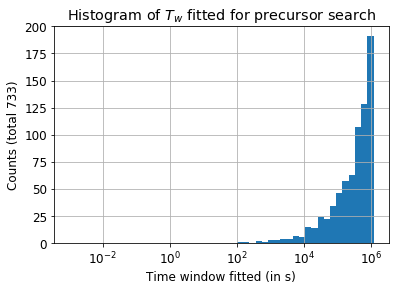

In [37]:
#Plotting the distribution of Time windows fitted for
plt.hist(Precursor_ID_TS_pv['dt']*86400, bins=np.logspace(np.log10(0.001),np.log10(14*86400), 50))
plt.xlabel('Time window fitted (in s)')
plt.ylabel('Counts (total 733)')
plt.grid()
plt.xscale('log')
plt.title('Histogram of $T_w$ fitted for the precursor search')
plt.savefig("T_w_fitted_s_precursor.png",dpi =200)
plt.show()

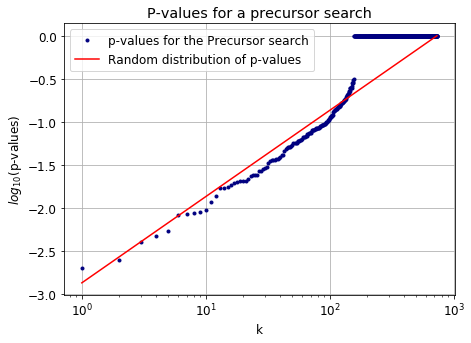

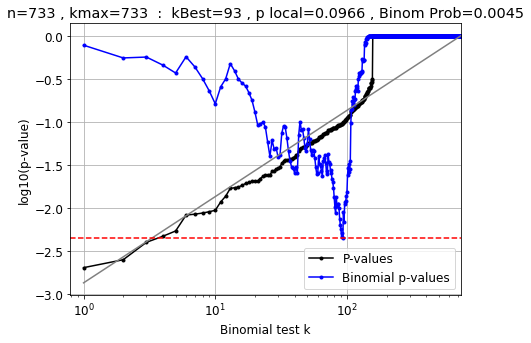

In [38]:
#Now we do the Binomial testing for the precursor search

pValues = np.sort(Precursor_ID_TS_pv['pv']) 
kmax = len(pValues)

#The Binomial test results
pBest_PC, kBest_PC, BpBest_PC, BpArr_PC = BinomialTest(pValues,kmax,returnArray=True)

#Plotting the Binomial test result

p_value_data = np.sort(Precursor_ID_TS_pv['pv'])
n = len(p_value_data)

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(1,n+1),np.log10(p_value_data), '.', color = 'navy', label ='p-values for the Precursor search')
plt.plot((1,n),(-np.log10(n),0),color='red', label = 'Random distribution of p-values')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$log_{10}$(p-values)')
plt.legend()
plt.title('P-values for the precursor search')
plt.grid()
plt.savefig("PV_PC.png")
plt.show()

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(1,n+1),np.log10(pValues),marker='.',color='black', label = 'P-values')
plt.plot(np.arange(1,n+1),np.log10(BpArr_PC),marker='.',color='blue', label = 'Binomial p-values')
plt.plot((1,n),(-np.log10(n),0),color='gray')
plt.xlim(10**(-0.1),n+(10**(0.1)))
plt.xscale('log')
plt.title('n='+str(n)+' , kmax='+str(kmax)+'  :  kBest='+str(kBest_PC)+' , p local={:.3g}'.format(pBest_PC)+ 
          ' , Binom Prob={:.2g}'.format(BpBest_PC))
plt.xlabel('Binomial test k')
plt.ylabel('log10(p-value)')
plt.axhline(np.log10(BpBest_PC),color = 'red',linestyle='--')
plt.grid()
plt.legend()
plt.savefig("BT_PC.png",dpi =200)
plt.show()


In [39]:
final_PV_PC = give_final_pv(Bp_distribution ,BpBest_PC)

158
0.03779904306220096


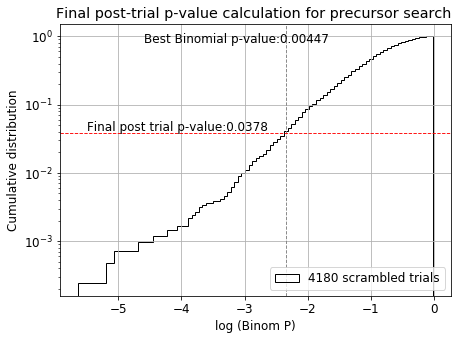

In [40]:
#Plotting the final PV
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.hist(np.log10(Bp_distribution), bins=100, cumulative=True, density=-1, histtype='step', color='black', label=str(len(Bp_distribution))+' scrambled trials')
plt.axvline(np.log10(BpBest_PC),color = 'grey', linestyle = '--', linewidth = 0.9)
plt.rcParams.update({'font.size': 12})
plt.text(-5.5, 1.1*final_PV_PC, r'Final post trial p-value:{:.3g}'.format(final_PV_PC))
plt.axhline(final_PV_PC ,color = 'red',linestyle = '--', linewidth = 0.9)
plt.text(-4.6, 0.8, r'Best Binomial p-value:{:.3g}'.format(BpBest_PC))
#plt.ylim(10**(-5),10**(0.2))
plt.xlabel('log (Binom P)')
plt.ylabel('Cumulative distribution')
plt.yscale('log')
plt.title('Final post-trial p-value calculation for the precursor search ')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("Final_PV_PC.png",dpi =200)
plt.show()

In [41]:
Top_k_GRBs_PC = SORTED_LIST_PC[:kBest_PC]

Top_k_GRBs_PC['dt'] = Top_k_GRBs_PC['dt']*86400

PC_TopKGRBS_pd = pd.DataFrame(Top_k_GRBs_PC, columns=['ID', 'ra', 'decl', 'mjd', 'dt', 'gamma', 'ns', 'ts', 'pv']) 
print(PC_TopKGRBS_pd)

     ID        ra     decl           mjd            dt     gamma        ns  \
0    74   98.1344 -58.6914  58098.394120  2.662695e+05  1.913732  2.235160   
1   448  207.5920   5.9710  56749.007014  1.953128e+02  4.000000  0.999416   
2   414  146.0550  63.5296  56847.635897  3.071090e+03  1.349597  0.998725   
3   433  227.2525  42.4182  56795.387338  4.781657e+05  1.802234  2.056710   
4    57   99.2653 -24.4961  58191.030091  4.673891e+04  2.808653  0.998610   
5   232  120.2568   7.6629  57495.183113  4.306863e+04  3.608926  2.137172   
6   422   27.1090 -39.2591  56827.485127  8.340409e+04  1.418126  0.996160   
7   582  147.5362 -42.3424  56334.150370  4.495635e+04  2.628377  0.996754   
8   259  109.0881 -23.5921  57408.576817  7.513006e+03  3.251330  0.995671   
9   250  147.5977   9.3696  57441.072481  5.333158e+03  4.000000  0.997444   
10  537   20.8535 -77.7734  56466.488017  1.126961e+05  1.846703  0.995462   
11  154  263.6332 -64.7604  57779.479633  5.394091e+04  1.524097

In [42]:
#Plotting the event details for the top-k GRBs

zed =1 
#This is to store the event details for the top -k cases
Top_k_trial_data_PC = []

for topk in Top_k_GRBs_PC:
    SB = give_S_over_B(PC_trs[topk['ID']],trial_from_kw)[0]
    Top_k_trial_data_PC.append(SB)
    SB_pd = pd.DataFrame(SB, columns=['S/B', 'event_index', 'run_ID', 'mjd']) 
    #mjd dtype changes somehow from 0.8decimal places to 0.6 decimal places when i use the pd.dataframe.
    #It however doesnt affect us much as we are going to put an upper bound to 0.5s anyways.
    #Use the pd.datafrme thign just to present m, not to store things.
    print('\n GRB #'+str(zed))
    print(PrettyPrintGrb(GRBs_of_interest[topk['ID']],Precursor_ID_TS_pv[topk['ID']]))
    print(SB_pd)
    zed = zed+1

    


 GRB #1
 RA= 98.1 Dec=-58.7 T0=58098.394120
 ns=2.24 p=2.0e-03  Tw=3.1e+00

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1498272  131609  58017.980908
1  0.000000e+00      1499090  131614  56840.150622
2  0.000000e+00      1499387  131620  57471.838988
3  0.000000e+00      1499870  131623  57526.567332
4  2.846377e+05      1228930  129640  58096.979744
5  1.064291e+07       426060  122671  58098.029448
6  2.159588e+08      1282464  130024  58095.312297

 GRB #2
 RA=207.6 Dec=  6.0 T0=56749.007014
 ns=1.00 p=2.5e-03  Tw=2.3e-03

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1498950  131613  55899.114558
1  0.000000e+00      1498984  131613  58186.581677
2  2.570671e+09       384893  122273  56749.004753

 GRB #3
 RA=146.1 Dec= 63.5 T0=56847.635897
 ns=1.00 p=4.0e-03  Tw=3.6e-02

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1499969  131623  57573.661256
1  0.000000e+00      1499971  131623  57608.759776
2  1


 GRB #23
 RA= 20.0 Dec=-35.8 T0=55986.607766
 ns=0.98 p=2.3e-02  Tw=1.9e+00

            S/B  event_index  run_ID           mjd
0  3.961315e+01        84950  118789  55986.235233
1  1.526038e+02       385390  122205  55984.859177
2  9.210395e+07      1475169  131445  55984.719172

 GRB #24
 RA=  4.7 Dec=  1.3 T0=57899.566065
 ns=0.99 p=2.4e-02  Tw=1.8e-02

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1499841  131623  56553.241296
1  0.000000e+00      1499971  131623  57608.759776
2  2.346865e+08        28697  118404  57899.547937

 GRB #25
 RA=340.1 Dec= 54.0 T0=55750.196782
 ns=1.20 p=2.4e-02  Tw=2.6e+00

            S/B  event_index  run_ID           mjd
0  3.875948e+03       758703  126128  55749.454693
1  4.885843e+03      1413356  131020  55750.183699
2  3.176253e+05         7683  118232  55748.587935
3  1.482126e+08       577678  124619  55747.551895

 GRB #26
 RA=327.1 Dec=-10.5 T0=55868.441123
 ns=0.98 p=2.4e-02  Tw=1.5e+00

            S/B  event_in


 GRB #45
 RA=249.6 Dec=-12.1 T0=57251.086894
 ns=0.92 p=4.9e-02  Tw=7.2e+00

            S/B  event_index  run_ID           mjd
0  2.308995e+03       591358  124707  57247.273056
1  2.014862e+04       727672  125872  57249.643713
2  1.556835e+07       959036  127592  57243.857545

 GRB #46
 RA= 97.6 Dec=-19.2 T0=57227.240683
 ns=0.95 p=5.1e-02  Tw=1.0e+01

            S/B  event_index  run_ID           mjd
0  1.400412e+04       226379  120428  57224.752612
1  1.580355e+04      1452526  131295  57224.004408
2  2.183033e+07      1494905  131585  57217.124026

 GRB #47
 RA=263.1 Dec=-44.7 T0=57818.295972
 ns=1.67 p=5.1e-02  Tw=9.9e+00

            S/B  event_index  run_ID           mjd
0  2.811340e+02       127770  119316  57814.789103
1  1.715115e+03       755443  126103  57816.581594
2  1.109902e+04      1104563  128704  57814.003581
3  3.733171e+06       908742  127180  57816.605985
4  4.990691e+06       595220  124750  57808.371922

 GRB #48
 RA=318.2 Dec=-50.0 T0=56117.883102
 ns=0.


 GRB #69
 RA=152.5 Dec=  5.0 T0=57786.769468
 ns=0.96 p=7.5e-02  Tw=3.5e-01

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1499803  131622  57474.608962
1  1.154430e+03       209888  120305  57786.509523
2  4.110404e+07      1472064  131427  57786.423325

 GRB #70
 RA=330.8 Dec=-65.5 T0=56500.698143
 ns=0.88 p=7.5e-02  Tw=1.6e+00

            S/B  event_index  run_ID           mjd
0  0.000000e+00      1497012  131603  56040.239237
1  0.000000e+00      1497225  131604  56127.081398
2  1.213090e+07       916777  127238  56499.092856

 GRB #71
 RA= 35.9 Dec= 67.5 T0=56510.119132
 ns=1.05 p=7.7e-02  Tw=3.5e+00

            S/B  event_index  run_ID           mjd
0  1.728930e+04       653833  125238  56507.636786
1  6.754244e+04       914794  127225  56509.664493
2  2.788722e+07       122014  119168  56506.659011

 GRB #72
 RA=218.8 Dec= -9.0 T0=56661.730592
 ns=0.79 p=8.0e-02  Tw=9.3e+00

            S/B  event_index  run_ID           mjd
0  2.119957e+04       743

In [44]:
#Searching for overlaps for the Precursor search

print('\nOnly for S/B>0')
Find_overlaps_in_trial(Top_k_trial_data_PC ,exclude_zero=True, verbose=True)
'''
print('\nAll overlaps including S/B=0')
Find_overlaps_in_trial(Top_k_trial_data_PC ,exclude_zero=False, verbose=True)
'''


Only for S/B>0
GRBs 90 and 92 have possible overlaps, event_nos:  [1368724]


"\nprint('\nAll overlaps including S/B=0')\nFind_overlaps_in_trial(Top_k_trial_data_PC ,exclude_zero=False, verbose=True)\n"